# 논문에서 설명하지 않은 Trnasformer Details

출처: [https://tunz.kr/post/4](https://tunz.kr/post/4)

# Transformer Details Not Described in The Paper
처음에는 논문을 구현하는 것이 매우 간단했지만, 곧바로, implementation과 tensor2tensor 코드 사이에 차이가 있음을 알게 되었습니다. 이는 논문이 발표된 이후, 많은 업데이트가 있었기 때문에 논문과 일치하지 않는 부분이 생겨났기 때문입니다.

이제 그 차이점을 대부분 알게 되었다고 생각하며, 구현하는 동안 발견한 내용을 공유하려고 합니다. 

tensor2tensor의 translate_ende_wmt32k_rev와 동일한 WMT de-en 데이터 세트를 사용했습니다. max_length, warmup 및 batch size는 각각 100, 16000 및 4096으로 설정했습니다.

# Pre/post-processing Sequence for Each Sub-Layer
직접 구현을 할때, pre/post-processing 순서가 논문과 다르다는 것을 발견했습니다.  각 sub-layer의 이전 버전 output은 다음과 같습니다:

$$\operatorname{LayerNorm}(x+\operatorname{SubLayer}(x))$$

하지만, 현재 버전의 output은 다음과 같이 바뀌었습니다.

$$x+\text { SubLayer }(\text { LayerNorm }(x))$$

또한, 마지막으로도 인코더/디코더의 최종 output을 normalization을 해야 합니다.

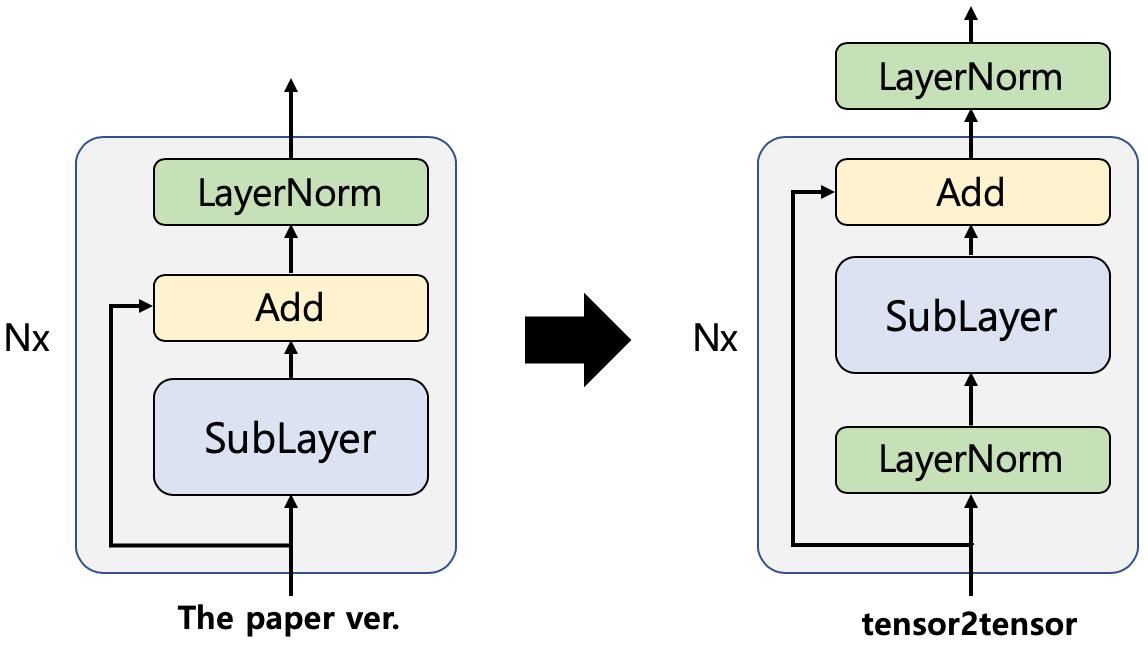

왼쪽과 오른쪽 figure는 논문 버전과 실제 implementation을 나타냅니다. 언뜻 보기에는 그냥 순서를 바꾸는 줄 알았는데 실제로는 그 이상입니다. 논문 버전은 residual connections를 추가한 후, sub-layer output을 normalization하지만, tensor2tensor는 sub-layer input만 normalization하고 residual connections은 건드리지 않습니다. 다음 figure는 이 새로운 아키텍처의 효과를 보여줍니다. baseline은 tensor2tensor의 실제 구현이고, 논문 버전은 이전 버전입니다. 보시다시피, loss의 큰 개선을 보여줍니다.

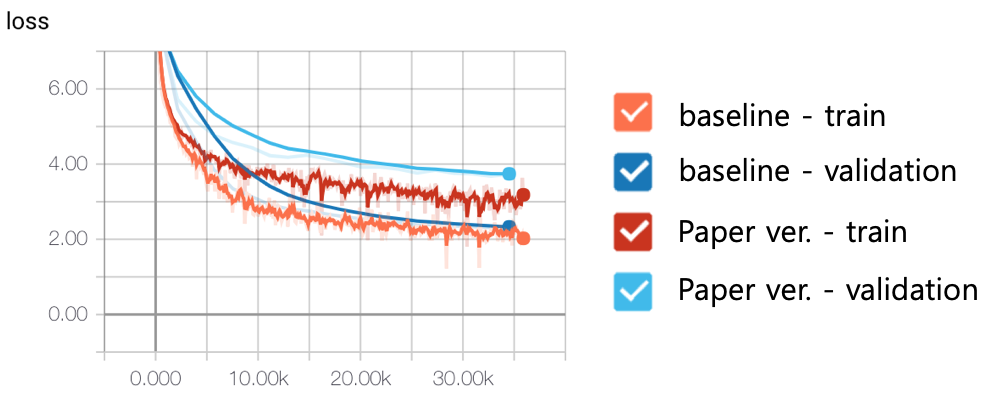

# Fast Decoding
Transformer는 RNN과 같은 autoregressive 계산을 피함으로써 좋은 품질을 얻을 수 있습니다. 그러나 training 단계와 달리 decoding(추론) 단계는 여전히 autoregressive여야 합니다. decoding 단계를 최적화하는 것은 production에 필수적입니다.

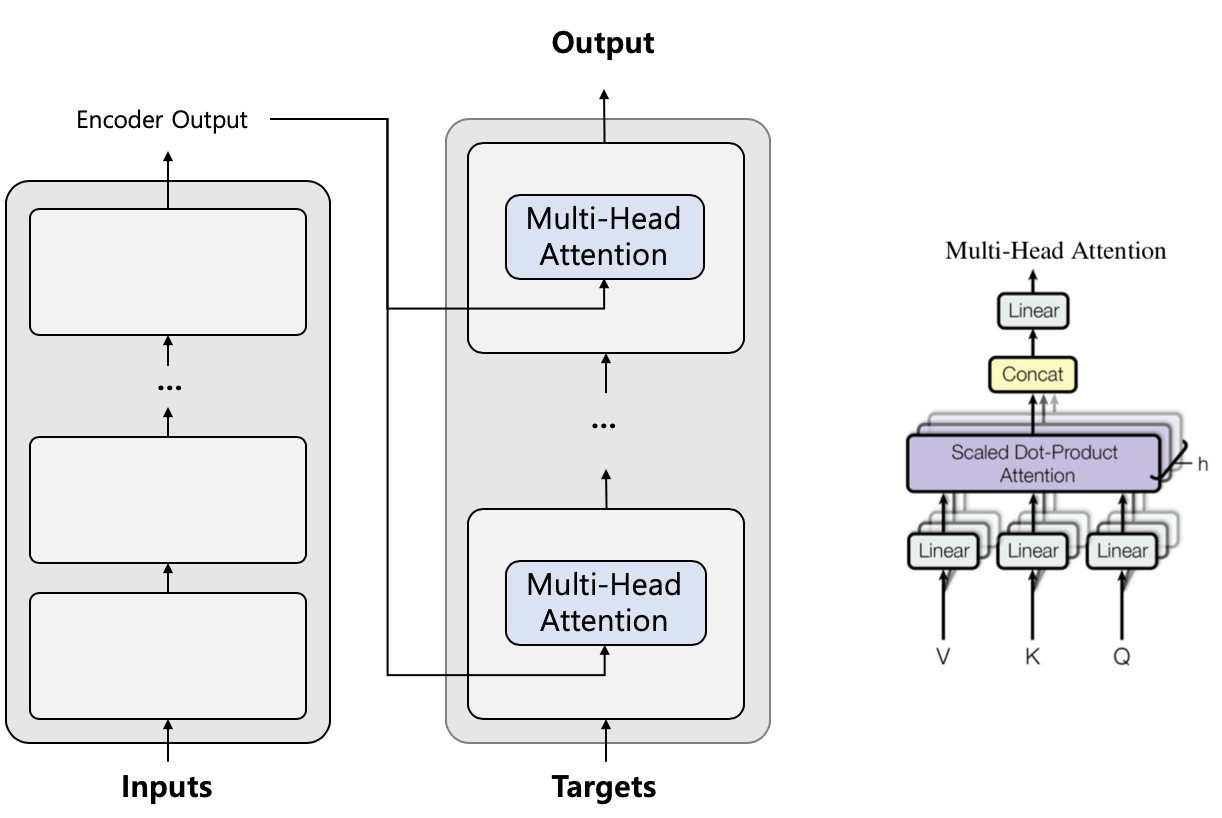

불필요한 반복 계산을 캐싱(caching)하여 autoregressive 단계를 최적화할 수 있습니다. 디코딩 단계는 Transformer에서 output을 얻은 후, target을 하나씩 확장해 EOS 토큰에 도달할 때까지 확장된 target을 전달합니다. 여기서 중요한 점은 input이 절대 변경되지 않는다는 것입니다. 인코더 output을 한 번만 가져와 나머지 디코딩 단계에 재사용하면 디코딩 속도가 1.33배 빨라집니다. 또한, 인코더 output은 인코더-디코더 attention를 위해 K와 V 값을 얻는 데 사용됩니다. 이러한 값을 유지하고 재사용할 수 있으므로 1.42배 빨라집니다.

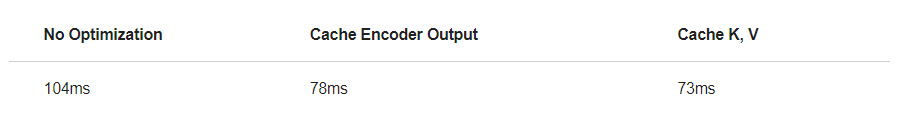

위의 내용이 여기서 찾은 빠른 디코딩에 대해 찾은 전부이지만, 최적화할 수 있는 것이 더 있을 것입니다. 예를 들어 previous targets에 대해 positional encoding이나 네트워크를 반복적으로 계산할 필요가 없습니다. 디코더의 self-attention 값의 절반은 attention mask 모양이 삼각형이기 때문에 0입니다. 그러면 [blocksparse](https://github.com/openai/blocksparse)와 같은 sparse computation 기술을 사용하여 계산을 피할 수 있습니다.

# Data Preprocessing
데이터를 공급하는 방법은 training의 성능에 많은 영향을 미칩니다. 이는 NLP 모델의 일반적인 training을 위한 주제일 수 있으므로 이 게시물에는 부적절할 수 있지만, tensor2tensor 코드에서 배운 것을 공유하려고 합니다.

## Paddings
NLP 작업에는 variable-length 데이터가 있으므로, mini batch에서 다른 input과 동일한 크기를 만들기 위해 padding을 추가해야 합니다. 그렇다면 두 가지 문제가 있습니다. 첫째, padding을 로드하고 계산하는 데 자원이 낭비됩니다. padding의 비율을 최소화할 수 있다면 train을 훨씬 빠르게 할 수 있습니다. 필자의 경우, 데이터의 60%가 padding일 때, training epoch마다 250초가 걸렸지만, padding의 비율을 5%로 줄인 후에는 100초가 되었습니다. 둘째, padding에 대한 계산은 노이즈가 될 수 있습니다. Transformer에서 padding은 normalization layers를 통과한 후, 0이 아닌 값이 됩니다. 이렇게 하면 각 padding에 대한 gradients를 만들어 불필요한 weight 업데이트가 발생합니다. 다른 많은 implementations가 이러한 문제를 처리하고 있음을 발견했습니다(예: 모든 sub-layers에서 padding을 0으로 재설정). 하지만, tensor2tensor는 인코더/디코더 layers의 padding을 처리하지 않습니다. embedding layers의 padding에 0을 곱하고 attention의 padding을 masking하여 input의 padding을 무시합니다.

tensor2tensor는 모델 자체에서 padding을 처리하는 것보다 padding의 비율을 줄이는 데 중점을 둡니다. 그들은 sequence lengths에 따른 bucketing(길이가 비슷한 데이터를 그룹화하면 batch에서 padding의 총 비율이 줄어 훈련 단계 효율성을 향상됨)을 사용합니다. 다음 figure에서 padding은 sequence 길이에 관계없이 순차적으로 데이터를 공급하는 것이고, baseline은 pytorch에서 ```tf.bucket_by_sequence_length```를 단순하게 구현한 것입니다.

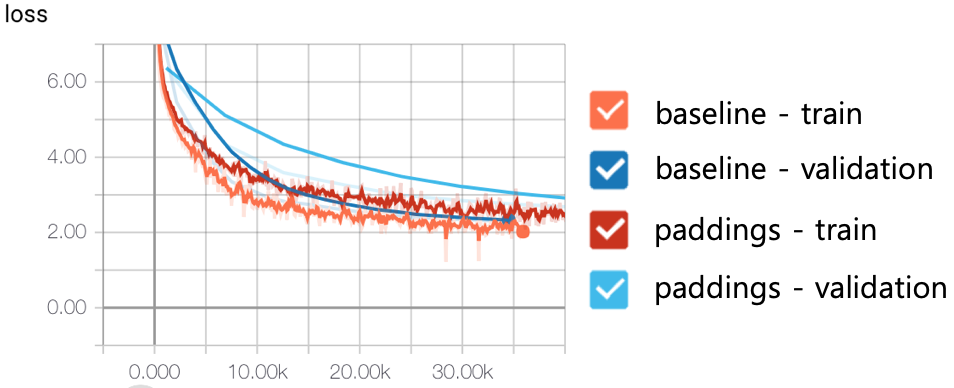

## Data Sharding
tensor2tensor는 데이터가 너무 크면 메모리의 모든 데이터를 로드할 수 없기 때문에 데이터 세트를 여러 shard로 분할합니다. 따라서, tensor2tensor는 training을 위해 각 shard를 하나씩 반복하고 로드합니다. 한 가지 중요한 점은 각 shard에 데이터 세트가 균등하게 분포되어 있다는 것입니다.

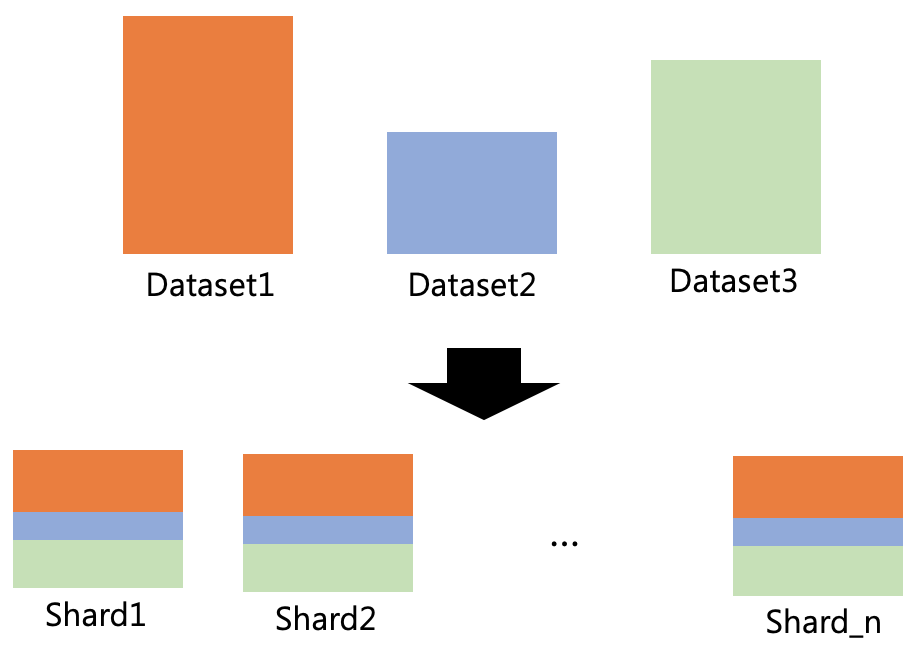

우리는 때때로 빅 데이터를 만들기 위해 여러 소스에서 데이터 세트를 수집합니다. 그러면 각 데이터 세트의 특성이 일치하지 않을 수 있으므로 순차적으로 공급하면 convergence of training이 느려질 수 있습니다. shuffling data는 문제를 처리하는 한 가지 옵션이지만, 빅 데이터 shuffling은 간단하지 않습니다. 따라서, tensor2tensor는 각 shard가 서로 다른 소스의 데이터 세트를 동일하게 분포하도록 만들고 전체 데이터 세트의 작은 부분만 shuffling 합니다. 이 strategy는 다음 figure과 같이 training을 안정화합니다. consecutive은 데이터 세트가 잘 분포되지 않은 데이터를 순차적으로 공급하는 것으로, validation set에서 변동이 많고 convergence가 느린 것을 보여줍니다.

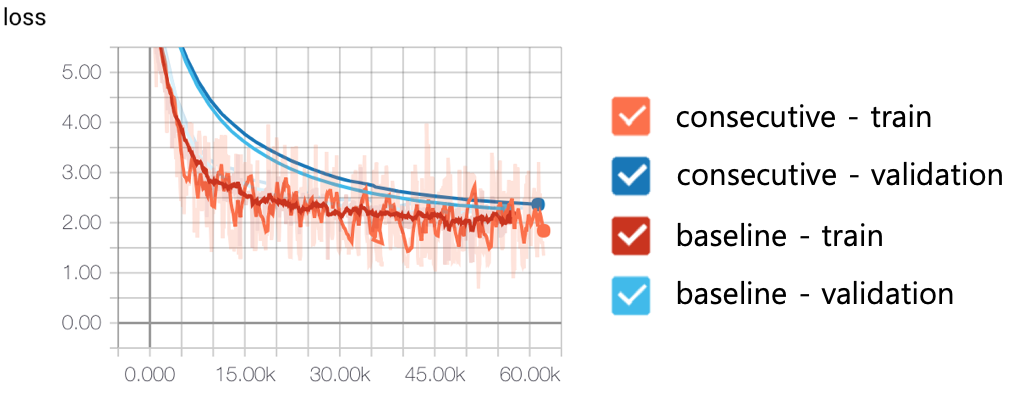

# Minors

## Weight Initialization
우리 모두 알다시피 weight initialization은 training의 중요한 요소 중 하나입니다. Xavier(glorot) uniform initializer with $1.0$의 이점은 인코더 및 디코더 layers를 위한 initializer입니다. 그리고 주의해야 할 또 한가지는 embedding layers를 random normal initializer with $0.0$ mean and $d_{\text {model }}^{-0.5}$ stddev로 초기화해야 한다는 것입니다.

## Positional Encoding
Transformer는 아래와 같은 위치 정보를 가지는 특별한 인코딩을 가지고 있습니다:

$$\begin{aligned}
P E_{(p o s, 2 i)} &=\sin \left(p o s / 10000^{2 i / d_{\text {model }}}\right) \\
P E_{(p o s, 2 i+1)} &=\cos \left(p o s / 10000^{2 i / d_{\text {model }}}\right)
\end{aligned}$$

하지만, 실제 implementation에서는 아래의 공식에 의한 positional encodings를 얻습니다:

$$\begin{array}{ll}
P E_{(p o s, i)}=\sin \left(\operatorname{pos} / 10000^{i /\left(d_{\text {model }} / 2-1\right)}\right) & \text { where } 0 \leq i<d_{\text {model }} / 2 \\
P E_{(p o s, i)}=\cos \left(\operatorname{pos} / 10000^{\left(i-d_{\text {model }} / 2\right) /\left(d_{\text {model }} / 2-1\right)}\right) & \text { where } d_{\text {model }} / 2 \leq i<d_{\text {model }}
\end{array}$$

Positional encoding은 상대 위치 간의 차이를 만들기 위한 heuristic이기 때문에 성능에 큰 차이를 만들지 않는다고 생각합니다.

## Dropout
이 논문에서는 각 sub-layer의 output과 embedding layer의 두 가지 dropout만 설명했습니다. 하지만, Transformer에는 두 개의 dropout이 더 추가됩니다. Transformer는 position-wise feed-forward networks에서 ReLU 이후에, 그리고 attention에서 SoftMax 이후에 dropout이 있습니다.

## Hyperparameter Settings
기본 hyperparameter 설정에 대한 업데이트가 많이 있습니다. 예를 들어, learning rate이 두 배가 되었습니다. Adam optimizer의 $β_2$를 $0.997$로 업데이트했습니다. 단일 GPU 및 기타에 대한 warmup 단계의 기본값도 $16000$와 $8000$으로 업데이트됩니다. layer normalization을 위한 Epsilon 값은 $10_{-6}$입니다.

# Conclusion
딥러닝은 대부분 실증적 연구를 기반으로 하기 때문에 일부 연구는 특정 문제에 overfitting됩니다. author가 깨닫지 못한 중요한 세부 사항이 있을 수 있거나, author가 그다지 중요하지 않은 점을 과도하게 강조할 수 있습니다. 때로는 의도하지 않은 구현으로 인해 성능이 향상됩니다. 따라서, 직접 모델을 실행해보는 것이 중요하고, 이 아키텍처를 직접 구현해보는 것을 추천합니다